# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [113]:
# can comment out after executing
# !unzip processed-celeba-small.zip

In [114]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [115]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [116]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    # get directories
    image_path = './' + data_dir + 'celeba/'

    # define datasets using ImageFolder
    im_dataset = datasets.ImageFolder(image_path, transform = transform)
    
    # create and return DataLoaders
    img_loader = DataLoader(im_dataset, batch_size = batch_size, shuffle=True)
    
    return img_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [117]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

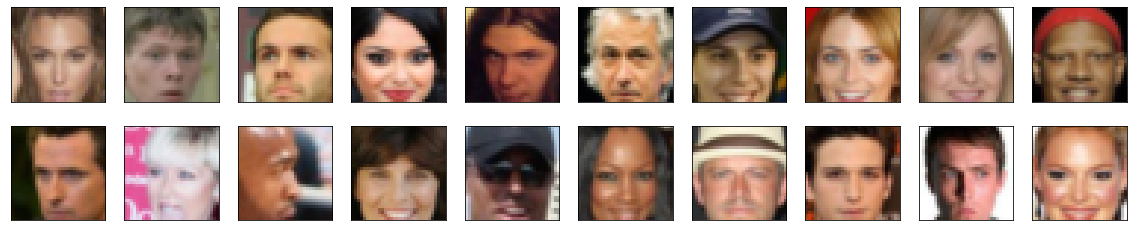

In [118]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [119]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [120]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8431)
Max:  tensor(0.7882)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [121]:
import torch.nn as nn
import torch.nn.functional as F

### Convolutional Helper Function

In [122]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Helper function derived from the GAN exercises that we worked on during this module
    """
    
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size,
                           stride = stride, padding = padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)    

In [123]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim

        # complete init function
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # 3x32x32 input, output dimx16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # dim*2x8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # dim*4x4x4
        # self.conv3 = conv(conv_dim*2, 1, 4, stride=1, batch_norm=False) # dim*4x4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, batch_norm=False)
        
        # classification layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        #x = self.conv4(x)
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fc(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [124]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    deconv function derived from from DCGAN exercise
    """
    layers = []
    
    deconv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                      stride=stride, padding=padding, bias=False)
    
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [125]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.z_size = z_size
        self.conv_dim = conv_dim

        # complete init function
        self.fc1 = nn.Linear(z_size, 4*4*4*conv_dim)
        self.tconv1 = deconv(4*conv_dim, 2*conv_dim, 4)
        self.tconv2 = deconv(2*conv_dim, conv_dim, 4)
        self.tconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1, 4*self.conv_dim, 4, 4)
        
        x = F.leaky_relu(self.tconv1(x))
        x = F.leaky_relu(self.tconv2(x))
        x = torch.tanh(self.tconv3(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [126]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    # code from mentor help in the Knowledge base: https://knowledge.udacity.com/questions/242873
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [127]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [128]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [129]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [130]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    # need a sigmoid on the discriminator
    # use BCE loss
    
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    #BCE with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    #BCE with logits loss
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [131]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

d_optimizer = optim.Adam(D.parameters(), lr, betas=[beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, betas=[beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [132]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            # Zero out gradients
            d_optimizer.zero_grad()
            # compute discriminator losses on real images
            d_real = D(real_images)
            d_real_loss = real_loss(d_real, smooth=True)
            
            # create fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            # add up losses and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            # zero gradients
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # compute the discriminator losses on fake images using flipped labels
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [133]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.8471 | g_loss: 7.7744
Epoch [    1/  100] | d_loss: 0.6039 | g_loss: 3.7813
Epoch [    1/  100] | d_loss: 0.6157 | g_loss: 4.2438
Epoch [    1/  100] | d_loss: 0.5462 | g_loss: 3.6251
Epoch [    1/  100] | d_loss: 0.7243 | g_loss: 3.5854
Epoch [    1/  100] | d_loss: 0.6286 | g_loss: 2.9675
Epoch [    1/  100] | d_loss: 0.5290 | g_loss: 3.9553
Epoch [    1/  100] | d_loss: 0.7739 | g_loss: 6.3695
Epoch [    1/  100] | d_loss: 0.8307 | g_loss: 4.1236
Epoch [    1/  100] | d_loss: 0.8769 | g_loss: 3.8691
Epoch [    1/  100] | d_loss: 1.0212 | g_loss: 4.9457
Epoch [    1/  100] | d_loss: 0.7191 | g_loss: 3.3073
Epoch [    1/  100] | d_loss: 0.9250 | g_loss: 3.8528
Epoch [    1/  100] | d_loss: 1.5866 | g_loss: 1.9583
Epoch [    1/  100] | d_loss: 0.7008 | g_loss: 4.0060
Epoch [    1/  100] | d_loss: 1.1047 | g_loss: 2.9920
Epoch [    1/  100] | d_loss: 1.1514 | g_loss: 2.4996
Epoch [    1/  100] | d_loss: 0.7850 | g_loss: 2.3828
Epoch [    1/  100] | d_loss

Epoch [    5/  100] | d_loss: 0.8263 | g_loss: 2.1850
Epoch [    5/  100] | d_loss: 0.6643 | g_loss: 2.2230
Epoch [    5/  100] | d_loss: 0.8327 | g_loss: 3.2648
Epoch [    5/  100] | d_loss: 0.8518 | g_loss: 2.5152
Epoch [    5/  100] | d_loss: 0.9725 | g_loss: 2.2425
Epoch [    5/  100] | d_loss: 0.6622 | g_loss: 2.5840
Epoch [    5/  100] | d_loss: 0.9751 | g_loss: 2.9200
Epoch [    5/  100] | d_loss: 0.8896 | g_loss: 1.7133
Epoch [    5/  100] | d_loss: 0.7363 | g_loss: 2.3211
Epoch [    5/  100] | d_loss: 1.1261 | g_loss: 2.9899
Epoch [    5/  100] | d_loss: 0.8872 | g_loss: 2.5913
Epoch [    5/  100] | d_loss: 1.3910 | g_loss: 2.9837
Epoch [    5/  100] | d_loss: 0.9521 | g_loss: 1.9678
Epoch [    5/  100] | d_loss: 0.7364 | g_loss: 2.0160
Epoch [    5/  100] | d_loss: 0.9582 | g_loss: 2.6168
Epoch [    5/  100] | d_loss: 0.6987 | g_loss: 1.9164
Epoch [    5/  100] | d_loss: 1.0597 | g_loss: 1.8482
Epoch [    5/  100] | d_loss: 0.9539 | g_loss: 2.8882
Epoch [    5/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.9468 | g_loss: 2.0799
Epoch [    9/  100] | d_loss: 1.0368 | g_loss: 1.2914
Epoch [    9/  100] | d_loss: 0.7364 | g_loss: 1.9591
Epoch [    9/  100] | d_loss: 0.6920 | g_loss: 3.3708
Epoch [    9/  100] | d_loss: 0.7944 | g_loss: 2.3544
Epoch [    9/  100] | d_loss: 1.3297 | g_loss: 1.0539
Epoch [    9/  100] | d_loss: 0.7713 | g_loss: 2.1096
Epoch [    9/  100] | d_loss: 0.5595 | g_loss: 1.6226
Epoch [    9/  100] | d_loss: 0.8174 | g_loss: 3.2340
Epoch [    9/  100] | d_loss: 1.1559 | g_loss: 0.6021
Epoch [    9/  100] | d_loss: 0.9310 | g_loss: 1.2421
Epoch [    9/  100] | d_loss: 0.6616 | g_loss: 3.6488
Epoch [    9/  100] | d_loss: 1.0689 | g_loss: 2.6995
Epoch [    9/  100] | d_loss: 0.8298 | g_loss: 4.1741
Epoch [    9/  100] | d_loss: 0.8260 | g_loss: 2.8425
Epoch [    9/  100] | d_loss: 0.8755 | g_loss: 2.4796
Epoch [    9/  100] | d_loss: 0.5295 | g_loss: 1.6367
Epoch [    9/  100] | d_loss: 0.7175 | g_loss: 3.3115
Epoch [    9/  100] | d_loss

Epoch [   13/  100] | d_loss: 0.6592 | g_loss: 2.9374
Epoch [   13/  100] | d_loss: 0.8254 | g_loss: 2.1269
Epoch [   13/  100] | d_loss: 0.6978 | g_loss: 2.8076
Epoch [   13/  100] | d_loss: 0.5998 | g_loss: 3.6835
Epoch [   13/  100] | d_loss: 0.5612 | g_loss: 3.9145
Epoch [   13/  100] | d_loss: 0.7576 | g_loss: 1.8057
Epoch [   13/  100] | d_loss: 0.7517 | g_loss: 2.2983
Epoch [   13/  100] | d_loss: 0.6648 | g_loss: 2.5494
Epoch [   13/  100] | d_loss: 0.5548 | g_loss: 2.8206
Epoch [   13/  100] | d_loss: 0.5171 | g_loss: 4.2154
Epoch [   13/  100] | d_loss: 0.8975 | g_loss: 2.8039
Epoch [   13/  100] | d_loss: 0.5606 | g_loss: 2.5561
Epoch [   14/  100] | d_loss: 0.6714 | g_loss: 2.4851
Epoch [   14/  100] | d_loss: 0.7431 | g_loss: 4.6938
Epoch [   14/  100] | d_loss: 0.5893 | g_loss: 3.0293
Epoch [   14/  100] | d_loss: 0.7746 | g_loss: 2.2045
Epoch [   14/  100] | d_loss: 0.5978 | g_loss: 2.4604
Epoch [   14/  100] | d_loss: 0.5018 | g_loss: 2.5549
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.7502 | g_loss: 1.8452
Epoch [   17/  100] | d_loss: 0.4966 | g_loss: 3.7399
Epoch [   17/  100] | d_loss: 0.6785 | g_loss: 1.7777
Epoch [   17/  100] | d_loss: 0.4692 | g_loss: 3.0566
Epoch [   18/  100] | d_loss: 0.5687 | g_loss: 4.5911
Epoch [   18/  100] | d_loss: 0.4924 | g_loss: 4.6901
Epoch [   18/  100] | d_loss: 0.5062 | g_loss: 3.5786
Epoch [   18/  100] | d_loss: 1.1065 | g_loss: 4.6422
Epoch [   18/  100] | d_loss: 0.6673 | g_loss: 2.4795
Epoch [   18/  100] | d_loss: 0.4498 | g_loss: 3.5532
Epoch [   18/  100] | d_loss: 0.4646 | g_loss: 2.6687
Epoch [   18/  100] | d_loss: 0.7091 | g_loss: 2.8304
Epoch [   18/  100] | d_loss: 0.5314 | g_loss: 3.9830
Epoch [   18/  100] | d_loss: 0.6166 | g_loss: 3.4272
Epoch [   18/  100] | d_loss: 0.5147 | g_loss: 3.3754
Epoch [   18/  100] | d_loss: 0.5551 | g_loss: 3.1158
Epoch [   18/  100] | d_loss: 2.8124 | g_loss: 0.1551
Epoch [   18/  100] | d_loss: 0.4331 | g_loss: 4.5647
Epoch [   18/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.9448 | g_loss: 2.0022
Epoch [   22/  100] | d_loss: 0.4840 | g_loss: 4.4022
Epoch [   22/  100] | d_loss: 0.5104 | g_loss: 4.5791
Epoch [   22/  100] | d_loss: 0.7023 | g_loss: 3.2204
Epoch [   22/  100] | d_loss: 0.4490 | g_loss: 3.9033
Epoch [   22/  100] | d_loss: 0.4235 | g_loss: 2.6611
Epoch [   22/  100] | d_loss: 0.4217 | g_loss: 4.5066
Epoch [   22/  100] | d_loss: 0.5811 | g_loss: 4.0780
Epoch [   22/  100] | d_loss: 0.6556 | g_loss: 4.3394
Epoch [   22/  100] | d_loss: 0.4994 | g_loss: 3.9731
Epoch [   22/  100] | d_loss: 0.4270 | g_loss: 2.9918
Epoch [   22/  100] | d_loss: 0.5283 | g_loss: 5.3556
Epoch [   22/  100] | d_loss: 1.1403 | g_loss: 4.2115
Epoch [   22/  100] | d_loss: 0.5202 | g_loss: 3.5951
Epoch [   22/  100] | d_loss: 0.4642 | g_loss: 4.5020
Epoch [   22/  100] | d_loss: 0.4914 | g_loss: 3.8887
Epoch [   22/  100] | d_loss: 0.5133 | g_loss: 5.3332
Epoch [   22/  100] | d_loss: 0.4942 | g_loss: 4.2551
Epoch [   22/  100] | d_loss

Epoch [   26/  100] | d_loss: 0.4909 | g_loss: 2.7122
Epoch [   26/  100] | d_loss: 0.5340 | g_loss: 4.7145
Epoch [   26/  100] | d_loss: 0.7842 | g_loss: 4.1384
Epoch [   26/  100] | d_loss: 0.6873 | g_loss: 1.6449
Epoch [   26/  100] | d_loss: 0.4900 | g_loss: 3.5546
Epoch [   26/  100] | d_loss: 0.5491 | g_loss: 3.5972
Epoch [   26/  100] | d_loss: 0.4238 | g_loss: 4.2323
Epoch [   26/  100] | d_loss: 0.6706 | g_loss: 5.4856
Epoch [   26/  100] | d_loss: 0.4895 | g_loss: 4.4088
Epoch [   26/  100] | d_loss: 0.5502 | g_loss: 3.7873
Epoch [   26/  100] | d_loss: 1.0962 | g_loss: 2.7838
Epoch [   26/  100] | d_loss: 0.4921 | g_loss: 3.8811
Epoch [   26/  100] | d_loss: 0.8016 | g_loss: 5.6839
Epoch [   26/  100] | d_loss: 2.8545 | g_loss: 8.7374
Epoch [   26/  100] | d_loss: 0.5160 | g_loss: 3.7542
Epoch [   26/  100] | d_loss: 0.5214 | g_loss: 3.0480
Epoch [   26/  100] | d_loss: 0.6377 | g_loss: 4.2162
Epoch [   26/  100] | d_loss: 0.4487 | g_loss: 3.5441
Epoch [   26/  100] | d_loss

Epoch [   30/  100] | d_loss: 0.4510 | g_loss: 4.8091
Epoch [   30/  100] | d_loss: 0.4257 | g_loss: 5.0184
Epoch [   30/  100] | d_loss: 1.6644 | g_loss: 7.2719
Epoch [   30/  100] | d_loss: 0.4571 | g_loss: 4.3622
Epoch [   30/  100] | d_loss: 0.5587 | g_loss: 3.4597
Epoch [   30/  100] | d_loss: 0.4866 | g_loss: 4.8060
Epoch [   30/  100] | d_loss: 0.5323 | g_loss: 2.8755
Epoch [   30/  100] | d_loss: 0.4549 | g_loss: 4.2234
Epoch [   30/  100] | d_loss: 0.5334 | g_loss: 4.2725
Epoch [   30/  100] | d_loss: 0.4123 | g_loss: 4.0906
Epoch [   30/  100] | d_loss: 0.6916 | g_loss: 2.4872
Epoch [   30/  100] | d_loss: 0.7841 | g_loss: 4.0757
Epoch [   30/  100] | d_loss: 0.4584 | g_loss: 4.6541
Epoch [   30/  100] | d_loss: 0.4458 | g_loss: 4.4811
Epoch [   30/  100] | d_loss: 0.5027 | g_loss: 2.7233
Epoch [   30/  100] | d_loss: 0.4840 | g_loss: 3.6851
Epoch [   31/  100] | d_loss: 0.4619 | g_loss: 3.7101
Epoch [   31/  100] | d_loss: 0.3854 | g_loss: 4.4341
Epoch [   31/  100] | d_loss

Epoch [   34/  100] | d_loss: 0.7202 | g_loss: 4.5257
Epoch [   34/  100] | d_loss: 0.4135 | g_loss: 3.8930
Epoch [   34/  100] | d_loss: 0.4217 | g_loss: 5.0574
Epoch [   34/  100] | d_loss: 0.6026 | g_loss: 3.1896
Epoch [   34/  100] | d_loss: 0.4794 | g_loss: 4.5886
Epoch [   34/  100] | d_loss: 0.4424 | g_loss: 3.6310
Epoch [   34/  100] | d_loss: 0.4655 | g_loss: 3.1371
Epoch [   34/  100] | d_loss: 0.3645 | g_loss: 5.3389
Epoch [   35/  100] | d_loss: 0.4086 | g_loss: 4.7749
Epoch [   35/  100] | d_loss: 0.8500 | g_loss: 2.3694
Epoch [   35/  100] | d_loss: 0.4578 | g_loss: 4.2906
Epoch [   35/  100] | d_loss: 0.5018 | g_loss: 3.1713
Epoch [   35/  100] | d_loss: 0.5004 | g_loss: 3.7681
Epoch [   35/  100] | d_loss: 0.4317 | g_loss: 5.3574
Epoch [   35/  100] | d_loss: 0.4020 | g_loss: 5.6780
Epoch [   35/  100] | d_loss: 0.5518 | g_loss: 5.8113
Epoch [   35/  100] | d_loss: 0.4531 | g_loss: 3.6506
Epoch [   35/  100] | d_loss: 0.4065 | g_loss: 3.7128
Epoch [   35/  100] | d_loss

Epoch [   39/  100] | d_loss: 0.4488 | g_loss: 4.1673
Epoch [   39/  100] | d_loss: 0.4536 | g_loss: 5.2512
Epoch [   39/  100] | d_loss: 0.4575 | g_loss: 3.8383
Epoch [   39/  100] | d_loss: 0.4622 | g_loss: 5.2638
Epoch [   39/  100] | d_loss: 0.4386 | g_loss: 4.4239
Epoch [   39/  100] | d_loss: 0.4823 | g_loss: 3.7977
Epoch [   39/  100] | d_loss: 0.4822 | g_loss: 5.7626
Epoch [   39/  100] | d_loss: 0.4302 | g_loss: 2.4819
Epoch [   39/  100] | d_loss: 0.5618 | g_loss: 3.8694
Epoch [   39/  100] | d_loss: 0.3908 | g_loss: 4.3190
Epoch [   39/  100] | d_loss: 0.5448 | g_loss: 3.3245
Epoch [   39/  100] | d_loss: 0.5373 | g_loss: 5.3033
Epoch [   39/  100] | d_loss: 0.4451 | g_loss: 3.7430
Epoch [   39/  100] | d_loss: 0.4612 | g_loss: 3.8861
Epoch [   39/  100] | d_loss: 0.8039 | g_loss: 2.0009
Epoch [   39/  100] | d_loss: 0.4300 | g_loss: 3.6760
Epoch [   39/  100] | d_loss: 0.4403 | g_loss: 4.6484
Epoch [   39/  100] | d_loss: 0.4236 | g_loss: 3.1416
Epoch [   39/  100] | d_loss

Epoch [   43/  100] | d_loss: 0.5271 | g_loss: 2.7201
Epoch [   43/  100] | d_loss: 0.4570 | g_loss: 6.1389
Epoch [   43/  100] | d_loss: 0.4629 | g_loss: 3.6531
Epoch [   43/  100] | d_loss: 0.4287 | g_loss: 5.1914
Epoch [   43/  100] | d_loss: 0.4015 | g_loss: 4.2568
Epoch [   43/  100] | d_loss: 0.5539 | g_loss: 3.1964
Epoch [   43/  100] | d_loss: 0.4186 | g_loss: 5.2194
Epoch [   43/  100] | d_loss: 0.4350 | g_loss: 3.5684
Epoch [   43/  100] | d_loss: 0.4210 | g_loss: 5.0836
Epoch [   43/  100] | d_loss: 0.3886 | g_loss: 4.3762
Epoch [   43/  100] | d_loss: 0.3545 | g_loss: 5.9279
Epoch [   43/  100] | d_loss: 0.4133 | g_loss: 5.6105
Epoch [   43/  100] | d_loss: 0.5674 | g_loss: 4.1044
Epoch [   43/  100] | d_loss: 0.4486 | g_loss: 5.3374
Epoch [   43/  100] | d_loss: 0.5726 | g_loss: 4.1639
Epoch [   43/  100] | d_loss: 0.3685 | g_loss: 3.4842
Epoch [   43/  100] | d_loss: 0.5299 | g_loss: 3.8256
Epoch [   43/  100] | d_loss: 0.4847 | g_loss: 4.3954
Epoch [   43/  100] | d_loss

Epoch [   47/  100] | d_loss: 0.4525 | g_loss: 4.2322
Epoch [   47/  100] | d_loss: 0.5206 | g_loss: 2.8823
Epoch [   47/  100] | d_loss: 0.4887 | g_loss: 4.9625
Epoch [   47/  100] | d_loss: 0.3913 | g_loss: 5.2096
Epoch [   47/  100] | d_loss: 0.5210 | g_loss: 3.0532
Epoch [   47/  100] | d_loss: 0.3731 | g_loss: 5.9968
Epoch [   47/  100] | d_loss: 0.4898 | g_loss: 3.5884
Epoch [   47/  100] | d_loss: 0.4252 | g_loss: 6.1081
Epoch [   47/  100] | d_loss: 0.3741 | g_loss: 5.6136
Epoch [   47/  100] | d_loss: 0.4138 | g_loss: 4.9282
Epoch [   47/  100] | d_loss: 0.4008 | g_loss: 4.1315
Epoch [   47/  100] | d_loss: 0.3923 | g_loss: 4.3941
Epoch [   47/  100] | d_loss: 0.3842 | g_loss: 5.2696
Epoch [   47/  100] | d_loss: 0.3936 | g_loss: 6.2266
Epoch [   47/  100] | d_loss: 0.4068 | g_loss: 5.0336
Epoch [   47/  100] | d_loss: 0.3698 | g_loss: 5.6819
Epoch [   47/  100] | d_loss: 0.4092 | g_loss: 4.1289
Epoch [   47/  100] | d_loss: 0.3997 | g_loss: 5.3500
Epoch [   47/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.4058 | g_loss: 4.4967
Epoch [   51/  100] | d_loss: 0.4506 | g_loss: 4.3304
Epoch [   51/  100] | d_loss: 0.3848 | g_loss: 4.5969
Epoch [   51/  100] | d_loss: 0.4632 | g_loss: 4.2264
Epoch [   51/  100] | d_loss: 0.5165 | g_loss: 3.6215
Epoch [   51/  100] | d_loss: 0.7669 | g_loss: 1.5599
Epoch [   51/  100] | d_loss: 0.3920 | g_loss: 7.1011
Epoch [   51/  100] | d_loss: 0.4856 | g_loss: 3.5822
Epoch [   51/  100] | d_loss: 0.4219 | g_loss: 5.0545
Epoch [   51/  100] | d_loss: 0.4524 | g_loss: 3.4605
Epoch [   51/  100] | d_loss: 0.4141 | g_loss: 4.2125
Epoch [   51/  100] | d_loss: 0.4868 | g_loss: 4.6378
Epoch [   52/  100] | d_loss: 0.3963 | g_loss: 6.0090
Epoch [   52/  100] | d_loss: 0.4201 | g_loss: 4.7289
Epoch [   52/  100] | d_loss: 0.4054 | g_loss: 6.0268
Epoch [   52/  100] | d_loss: 0.9830 | g_loss: 4.8983
Epoch [   52/  100] | d_loss: 0.4193 | g_loss: 5.2130
Epoch [   52/  100] | d_loss: 0.4449 | g_loss: 4.8151
Epoch [   52/  100] | d_loss

Epoch [   55/  100] | d_loss: 0.6179 | g_loss: 2.5290
Epoch [   55/  100] | d_loss: 0.3930 | g_loss: 5.4190
Epoch [   55/  100] | d_loss: 0.4305 | g_loss: 5.2088
Epoch [   55/  100] | d_loss: 0.4293 | g_loss: 4.8947
Epoch [   56/  100] | d_loss: 0.4957 | g_loss: 5.2226
Epoch [   56/  100] | d_loss: 0.4015 | g_loss: 4.8479
Epoch [   56/  100] | d_loss: 0.4111 | g_loss: 4.9723
Epoch [   56/  100] | d_loss: 0.3907 | g_loss: 5.5888
Epoch [   56/  100] | d_loss: 0.5043 | g_loss: 4.5057
Epoch [   56/  100] | d_loss: 0.4135 | g_loss: 5.5281
Epoch [   56/  100] | d_loss: 0.4713 | g_loss: 4.7287
Epoch [   56/  100] | d_loss: 0.6234 | g_loss: 3.2591
Epoch [   56/  100] | d_loss: 0.4492 | g_loss: 3.6282
Epoch [   56/  100] | d_loss: 0.3735 | g_loss: 5.3229
Epoch [   56/  100] | d_loss: 0.3950 | g_loss: 5.0415
Epoch [   56/  100] | d_loss: 0.3789 | g_loss: 4.9841
Epoch [   56/  100] | d_loss: 0.3731 | g_loss: 3.9794
Epoch [   56/  100] | d_loss: 0.3857 | g_loss: 4.4330
Epoch [   56/  100] | d_loss

Epoch [   60/  100] | d_loss: 0.4612 | g_loss: 3.9747
Epoch [   60/  100] | d_loss: 0.4598 | g_loss: 3.7828
Epoch [   60/  100] | d_loss: 0.5107 | g_loss: 3.4925
Epoch [   60/  100] | d_loss: 0.4022 | g_loss: 8.7559
Epoch [   60/  100] | d_loss: 0.4053 | g_loss: 3.8941
Epoch [   60/  100] | d_loss: 0.7374 | g_loss: 1.6752
Epoch [   60/  100] | d_loss: 0.3958 | g_loss: 4.2688
Epoch [   60/  100] | d_loss: 0.3746 | g_loss: 5.2589
Epoch [   60/  100] | d_loss: 0.3571 | g_loss: 5.6922
Epoch [   60/  100] | d_loss: 0.3720 | g_loss: 4.3279
Epoch [   60/  100] | d_loss: 0.4203 | g_loss: 5.2257
Epoch [   60/  100] | d_loss: 0.3824 | g_loss: 5.9079
Epoch [   60/  100] | d_loss: 0.5130 | g_loss: 3.3053
Epoch [   60/  100] | d_loss: 0.5710 | g_loss: 3.0638
Epoch [   60/  100] | d_loss: 0.3634 | g_loss: 5.2039
Epoch [   60/  100] | d_loss: 0.4325 | g_loss: 4.2906
Epoch [   60/  100] | d_loss: 0.6082 | g_loss: 5.0882
Epoch [   60/  100] | d_loss: 0.3723 | g_loss: 6.8198
Epoch [   60/  100] | d_loss

Epoch [   64/  100] | d_loss: 0.4522 | g_loss: 3.6107
Epoch [   64/  100] | d_loss: 0.3719 | g_loss: 6.2991
Epoch [   64/  100] | d_loss: 0.3705 | g_loss: 5.5100
Epoch [   64/  100] | d_loss: 0.5117 | g_loss: 4.9008
Epoch [   64/  100] | d_loss: 0.4712 | g_loss: 4.6445
Epoch [   64/  100] | d_loss: 0.4179 | g_loss: 4.8368
Epoch [   64/  100] | d_loss: 0.4253 | g_loss: 4.6732
Epoch [   64/  100] | d_loss: 0.4286 | g_loss: 4.7558
Epoch [   64/  100] | d_loss: 0.3860 | g_loss: 6.3319
Epoch [   64/  100] | d_loss: 0.3586 | g_loss: 7.4649
Epoch [   64/  100] | d_loss: 0.3990 | g_loss: 4.8265
Epoch [   64/  100] | d_loss: 0.3667 | g_loss: 4.6179
Epoch [   64/  100] | d_loss: 0.4075 | g_loss: 4.2652
Epoch [   64/  100] | d_loss: 0.3804 | g_loss: 5.4108
Epoch [   64/  100] | d_loss: 0.4168 | g_loss: 4.3840
Epoch [   64/  100] | d_loss: 0.3685 | g_loss: 4.3968
Epoch [   64/  100] | d_loss: 0.3658 | g_loss: 5.4069
Epoch [   64/  100] | d_loss: 0.3875 | g_loss: 6.0893
Epoch [   64/  100] | d_loss

Epoch [   68/  100] | d_loss: 0.4503 | g_loss: 5.3373
Epoch [   68/  100] | d_loss: 0.4236 | g_loss: 5.4854
Epoch [   68/  100] | d_loss: 0.4369 | g_loss: 4.6267
Epoch [   68/  100] | d_loss: 0.3888 | g_loss: 6.3001
Epoch [   68/  100] | d_loss: 0.4128 | g_loss: 5.7433
Epoch [   68/  100] | d_loss: 0.3698 | g_loss: 5.5391
Epoch [   68/  100] | d_loss: 0.3887 | g_loss: 4.6821
Epoch [   68/  100] | d_loss: 0.3909 | g_loss: 5.9472
Epoch [   68/  100] | d_loss: 0.4430 | g_loss: 5.5931
Epoch [   68/  100] | d_loss: 0.3579 | g_loss: 4.7997
Epoch [   68/  100] | d_loss: 0.3670 | g_loss: 5.9187
Epoch [   68/  100] | d_loss: 0.4194 | g_loss: 5.4598
Epoch [   68/  100] | d_loss: 0.4195 | g_loss: 4.7647
Epoch [   68/  100] | d_loss: 0.4238 | g_loss: 5.5895
Epoch [   68/  100] | d_loss: 0.3723 | g_loss: 6.5398
Epoch [   68/  100] | d_loss: 0.4228 | g_loss: 4.5723
Epoch [   69/  100] | d_loss: 0.4391 | g_loss: 6.0163
Epoch [   69/  100] | d_loss: 0.3872 | g_loss: 5.6031
Epoch [   69/  100] | d_loss

Epoch [   72/  100] | d_loss: 0.3988 | g_loss: 5.2664
Epoch [   72/  100] | d_loss: 0.3711 | g_loss: 6.6378
Epoch [   72/  100] | d_loss: 0.3844 | g_loss: 5.0604
Epoch [   72/  100] | d_loss: 0.3625 | g_loss: 4.7548
Epoch [   72/  100] | d_loss: 0.4123 | g_loss: 4.1119
Epoch [   72/  100] | d_loss: 0.3602 | g_loss: 4.4815
Epoch [   72/  100] | d_loss: 0.3586 | g_loss: 5.2968
Epoch [   72/  100] | d_loss: 0.3727 | g_loss: 6.2395
Epoch [   73/  100] | d_loss: 0.3760 | g_loss: 6.4924
Epoch [   73/  100] | d_loss: 0.4106 | g_loss: 3.7402
Epoch [   73/  100] | d_loss: 0.3847 | g_loss: 4.3785
Epoch [   73/  100] | d_loss: 0.3876 | g_loss: 4.7281
Epoch [   73/  100] | d_loss: 0.5249 | g_loss: 5.0367
Epoch [   73/  100] | d_loss: 0.3858 | g_loss: 5.9563
Epoch [   73/  100] | d_loss: 0.3598 | g_loss: 4.4408
Epoch [   73/  100] | d_loss: 0.3776 | g_loss: 5.0340
Epoch [   73/  100] | d_loss: 0.3709 | g_loss: 5.2088
Epoch [   73/  100] | d_loss: 0.3763 | g_loss: 4.7806
Epoch [   73/  100] | d_loss

Epoch [   77/  100] | d_loss: 0.3707 | g_loss: 6.6930
Epoch [   77/  100] | d_loss: 0.3693 | g_loss: 4.5106
Epoch [   77/  100] | d_loss: 0.3864 | g_loss: 6.2180
Epoch [   77/  100] | d_loss: 0.3649 | g_loss: 7.5516
Epoch [   77/  100] | d_loss: 0.4692 | g_loss: 3.7194
Epoch [   77/  100] | d_loss: 0.3649 | g_loss: 5.4991
Epoch [   77/  100] | d_loss: 0.3606 | g_loss: 6.3001
Epoch [   77/  100] | d_loss: 0.5258 | g_loss: 3.2959
Epoch [   77/  100] | d_loss: 0.3829 | g_loss: 5.0201
Epoch [   77/  100] | d_loss: 0.4024 | g_loss: 6.9745
Epoch [   77/  100] | d_loss: 0.5236 | g_loss: 2.3536
Epoch [   77/  100] | d_loss: 0.4342 | g_loss: 5.2510
Epoch [   77/  100] | d_loss: 0.3906 | g_loss: 4.7834
Epoch [   77/  100] | d_loss: 0.3818 | g_loss: 5.5127
Epoch [   77/  100] | d_loss: 0.3626 | g_loss: 5.5684
Epoch [   77/  100] | d_loss: 0.3508 | g_loss: 6.0154
Epoch [   77/  100] | d_loss: 0.3637 | g_loss: 5.5916
Epoch [   77/  100] | d_loss: 0.4560 | g_loss: 3.6478
Epoch [   77/  100] | d_loss

Epoch [   81/  100] | d_loss: 0.3842 | g_loss: 6.3596
Epoch [   82/  100] | d_loss: 0.3724 | g_loss: 5.9734
Epoch [   82/  100] | d_loss: 0.3694 | g_loss: 7.4769
Epoch [   82/  100] | d_loss: 0.3676 | g_loss: 5.3779
Epoch [   82/  100] | d_loss: 0.3474 | g_loss: 5.7584
Epoch [   82/  100] | d_loss: 0.3579 | g_loss: 6.0758
Epoch [   82/  100] | d_loss: 0.3672 | g_loss: 5.5963
Epoch [   82/  100] | d_loss: 0.4011 | g_loss: 5.3374
Epoch [   82/  100] | d_loss: 0.4051 | g_loss: 4.4315
Epoch [   82/  100] | d_loss: 0.3702 | g_loss: 5.3687
Epoch [   82/  100] | d_loss: 0.4359 | g_loss: 3.5419
Epoch [   82/  100] | d_loss: 0.3554 | g_loss: 6.2553
Epoch [   82/  100] | d_loss: 0.3596 | g_loss: 6.8258
Epoch [   82/  100] | d_loss: 0.3658 | g_loss: 5.5252
Epoch [   82/  100] | d_loss: 0.3547 | g_loss: 4.7283
Epoch [   82/  100] | d_loss: 0.4543 | g_loss: 2.7483
Epoch [   82/  100] | d_loss: 0.4776 | g_loss: 3.7403
Epoch [   82/  100] | d_loss: 0.4416 | g_loss: 5.3314
Epoch [   82/  100] | d_loss

Epoch [   86/  100] | d_loss: 0.3669 | g_loss: 5.0229
Epoch [   86/  100] | d_loss: 0.3572 | g_loss: 5.4193
Epoch [   86/  100] | d_loss: 0.3745 | g_loss: 6.1537
Epoch [   86/  100] | d_loss: 0.3562 | g_loss: 7.6491
Epoch [   86/  100] | d_loss: 0.3552 | g_loss: 5.5025
Epoch [   86/  100] | d_loss: 0.3747 | g_loss: 5.1582
Epoch [   86/  100] | d_loss: 0.3652 | g_loss: 5.3723
Epoch [   86/  100] | d_loss: 0.3869 | g_loss: 5.4162
Epoch [   86/  100] | d_loss: 0.3779 | g_loss: 6.1797
Epoch [   86/  100] | d_loss: 0.3639 | g_loss: 6.7458
Epoch [   86/  100] | d_loss: 0.3579 | g_loss: 5.2458
Epoch [   86/  100] | d_loss: 0.3759 | g_loss: 6.7512
Epoch [   86/  100] | d_loss: 0.3804 | g_loss: 5.5957
Epoch [   86/  100] | d_loss: 0.3814 | g_loss: 6.3181
Epoch [   86/  100] | d_loss: 0.4056 | g_loss: 5.2563
Epoch [   86/  100] | d_loss: 0.3591 | g_loss: 6.6784
Epoch [   86/  100] | d_loss: 0.4488 | g_loss: 3.8075
Epoch [   86/  100] | d_loss: 0.3884 | g_loss: 4.4207
Epoch [   86/  100] | d_loss

Epoch [   90/  100] | d_loss: 0.4710 | g_loss: 3.5146
Epoch [   90/  100] | d_loss: 0.3832 | g_loss: 4.9680
Epoch [   90/  100] | d_loss: 0.3583 | g_loss: 7.7346
Epoch [   90/  100] | d_loss: 0.3771 | g_loss: 5.8764
Epoch [   90/  100] | d_loss: 0.3536 | g_loss: 7.4712
Epoch [   90/  100] | d_loss: 0.3522 | g_loss: 6.7018
Epoch [   90/  100] | d_loss: 0.3784 | g_loss: 4.4100
Epoch [   90/  100] | d_loss: 0.3792 | g_loss: 5.3239
Epoch [   90/  100] | d_loss: 0.4025 | g_loss: 5.5223
Epoch [   90/  100] | d_loss: 0.3685 | g_loss: 5.3437
Epoch [   90/  100] | d_loss: 0.3682 | g_loss: 5.9145
Epoch [   90/  100] | d_loss: 0.3886 | g_loss: 6.1126
Epoch [   90/  100] | d_loss: 0.3502 | g_loss: 7.0792
Epoch [   90/  100] | d_loss: 0.3555 | g_loss: 6.5468
Epoch [   90/  100] | d_loss: 0.3929 | g_loss: 6.1587
Epoch [   90/  100] | d_loss: 0.3824 | g_loss: 5.3805
Epoch [   90/  100] | d_loss: 0.3784 | g_loss: 5.9063
Epoch [   90/  100] | d_loss: 0.3928 | g_loss: 4.2857
Epoch [   90/  100] | d_loss

Epoch [   94/  100] | d_loss: 0.4110 | g_loss: 5.6212
Epoch [   94/  100] | d_loss: 0.3784 | g_loss: 6.9305
Epoch [   94/  100] | d_loss: 0.3642 | g_loss: 6.5533
Epoch [   94/  100] | d_loss: 0.3692 | g_loss: 6.8421
Epoch [   94/  100] | d_loss: 0.3833 | g_loss: 5.9965
Epoch [   94/  100] | d_loss: 0.3769 | g_loss: 4.7123
Epoch [   94/  100] | d_loss: 0.3723 | g_loss: 6.2001
Epoch [   94/  100] | d_loss: 0.3587 | g_loss: 7.2241
Epoch [   94/  100] | d_loss: 0.3854 | g_loss: 5.3659
Epoch [   94/  100] | d_loss: 0.4260 | g_loss: 5.0158
Epoch [   94/  100] | d_loss: 0.3792 | g_loss: 5.5858
Epoch [   94/  100] | d_loss: 0.3700 | g_loss: 6.0732
Epoch [   94/  100] | d_loss: 0.3669 | g_loss: 5.6656
Epoch [   95/  100] | d_loss: 0.5927 | g_loss: 6.8355
Epoch [   95/  100] | d_loss: 0.3741 | g_loss: 5.7241
Epoch [   95/  100] | d_loss: 0.5088 | g_loss: 3.1137
Epoch [   95/  100] | d_loss: 0.3803 | g_loss: 7.2306
Epoch [   95/  100] | d_loss: 0.4141 | g_loss: 3.5710
Epoch [   95/  100] | d_loss

Epoch [   98/  100] | d_loss: 0.3475 | g_loss: 5.0635
Epoch [   98/  100] | d_loss: 0.3485 | g_loss: 5.9697
Epoch [   98/  100] | d_loss: 0.3566 | g_loss: 8.1267
Epoch [   98/  100] | d_loss: 0.3899 | g_loss: 6.9286
Epoch [   98/  100] | d_loss: 0.3609 | g_loss: 6.5562
Epoch [   99/  100] | d_loss: 0.6575 | g_loss: 3.0829
Epoch [   99/  100] | d_loss: 0.4452 | g_loss: 5.5406
Epoch [   99/  100] | d_loss: 0.5255 | g_loss: 5.6908
Epoch [   99/  100] | d_loss: 0.3671 | g_loss: 6.7263
Epoch [   99/  100] | d_loss: 0.4052 | g_loss: 5.2131
Epoch [   99/  100] | d_loss: 0.3613 | g_loss: 4.6690
Epoch [   99/  100] | d_loss: 0.4242 | g_loss: 5.6125
Epoch [   99/  100] | d_loss: 0.3943 | g_loss: 5.6352
Epoch [   99/  100] | d_loss: 0.3882 | g_loss: 5.3550
Epoch [   99/  100] | d_loss: 0.3570 | g_loss: 5.0808
Epoch [   99/  100] | d_loss: 0.3679 | g_loss: 4.2531
Epoch [   99/  100] | d_loss: 0.3696 | g_loss: 5.7626
Epoch [   99/  100] | d_loss: 0.3777 | g_loss: 6.3056
Epoch [   99/  100] | d_loss

/state/partition1/llgrid/pkg/anaconda/anaconda3-2020b/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

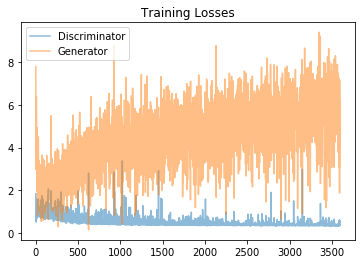

In [134]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [135]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [136]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

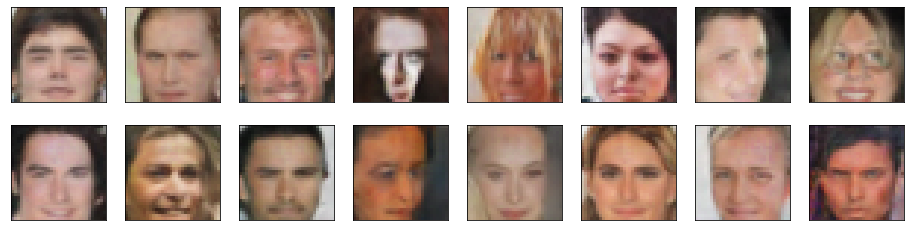

In [137]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.